# Exercise 3

In [ ]:
using Pkg
Pkg.activate(".")
Pkg.add(["Plots", "DifferentialEquations"])
using Plots, DifferentialEquations

## 1. Stability of a Double Well 

Explore the stability of the system
$$\frac{dx}{dt} = x - x^3.$$

What are the fixed points of the system and what's their stability? Which intervals of initial conditions lead to which of the stable fixed points?

#### Solution
- The system has three fixed points at $x_{*1}=-1$, $x_{*2}=0$, and $x_{*3}=1$.
<br><br>
- $x_{*1}$ and $x_{*3}$ are stable and $x_{*2}$ is unstable.
<br><br>
- This ODE is also connected to a double well potential $V=-\frac{1}{2}x^2 + \frac{1}{4}x^4 +C$, and $\frac{dx}{dt} = f(x)= -\frac{dV}{dx}$. When we can write an ODE like this, we can also inspect this potential $V$. Trajectories / "Particles" always move towards minima of the potential. This also showcases very well that this is a bistable system. Initial conditions $x_0<0$ always move towards the minima at -1 wheareas initial conditions $x_0>0$ move towards the minima at +1. 

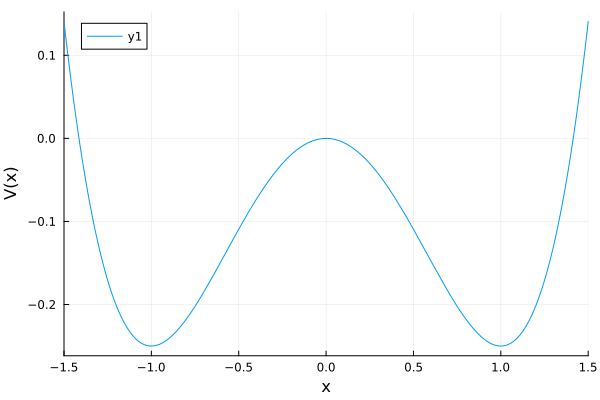

In [2]:
plot(x -> -0.5x^2 + 0.25x^4, xlims = [-1.5, 1.5], ylabel = "V(x)", xlabel = "x")

## 2. Phase Portraits and Lotka-Volterra

### Lotka-Volterra Model for Competition 

First, we do a slightly different Lotka-Volterra Model, its variation for competition. Imagine we have a population of rabbits and and one of sheeps. Both are competing for the same limited food supply (grass). Similar to the logistic growth model, each population will have its own carrying capacity. Both reproduce, but rabbits reproduce a bit faster than sheep. When a sheep and a rabbit compete for the same patch of grass, the sheep will more often "win" and chase the rabbit away than the other way around. These conflicts occur more often when the populations are larger, thus we assume they are directly proportional to their population. 

One of modelling this is done by the following equation: 

$$\begin{align}\frac{dR}{dt} &= R(3 - R - 2S)\\
\frac{dS}{dt} &= S(2 - S - R)\end{align}$$

The first two terms correspond to the logistic growth of each seperate species, where rabbits reproduce a bit faster. The last term models the conflicts between two species. 

* Now, implement this model and plot a phase portrait similar to how it was done in the lecture. From the phase portrait deduct the stability of the system and what kind of behaviour occurs. 

#### Solution

Let's first copy over the phase plots functions from the lecture. We'll adjust the code a little bit to incorporate some of the parametric types we learned about. 

In [8]:
struct PhasePlot{P <: ODEProblem}
    prob::P
end

# We extend the function plot from the Plots.jl package
function Plots.plot(phase_plot::PhasePlot, x_range, y_range, p = nothing; condition = (x,y) -> false, kwargs...) 
    p = isnothing(p) ? phase_plot.prob.p : p
    
    fig = plot() #size = (500, 500))
    for x in x_range, y in y_range
        # if the condition is met we skip to plot some points to have a cleaner plot
        if condition(x, y) & (rand() < 0.85)
            continue 
        end 
        
        prob = remake(phase_plot.prob; u0 = [x, y], p = p)
        sol = solve(prob)
        
        plot!(
            fig,
            sol,
            idxs = (1, 2);
            arrows = true,
            legend = nothing,
            linewidth = 2,
            xlabel = "x",
            ylabel = "y",
            xlims = [x_range[1], x_range[end]], 
            ylims = [y_range[1], y_range[end]],
            color = :black,
            kwargs...,
        )
    end    
    return fig
end 

Now we implement the update rule for the Lotka-Volterra model for competition and solve it.

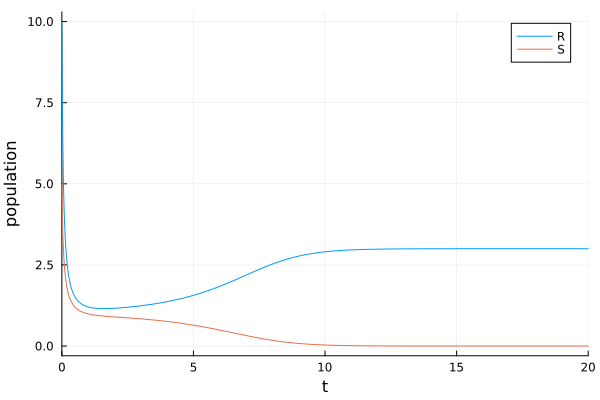

In [4]:
function competition(u, p, t)
    R, S = u
    return [R * (3 - R - 2S), S * (2 - S - R)]
end

u0 = [10.0, 5.0]
tspan = (0.0, 20.0)
p = nothing  # Remember from earlier that p can optionally have type Nothing
prob = ODEProblem(competition, u0, tspan, p)
sol = solve(prob)

plot(sol, xlabel = "t", ylabel = "population", label = ["R" "S"])

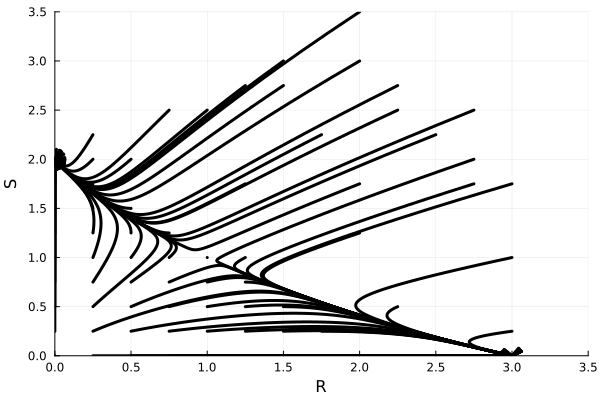

In [5]:
x_grid = 0:0.25:3.5
y_grid = 0:0.25:3.5

phase_plot = PhasePlot(prob)
plot(
    phase_plot,
    x_grid,
    y_grid;
    legend = nothing, 
    linewidth = 3,
    xlabel = "R",
    ylabel = "S",
    condition = (x, y) -> y > (2 - x),
)  

We have stable nodes / sinks at $(0,2)$ and $(3,0)$, an unstable node at $(0,0)$ and a saddle point at $(1,1)$. $(0,2)$ and $(3,0)$ are the only two stable points and eventually all trajectories will end in of them. Any part of the phase space whose initial conditions lead to one attractor (here the stable node) is called its basin of attraction (often short just basin). This model therefore has two different basins of attraction. One to the top left of the stable manifold of the saddle point. All trajectories that start there will lead to the stable node at $(3,0)$. The other at the lower right will lead to the stable node at $(0,2)$. The stable manifold of the saddle point here is therefore also the basin boundary. 

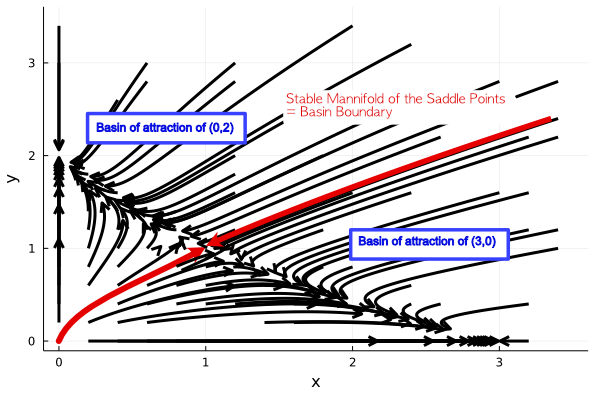

### Lotka-Volterra Model for Predator-Prey Dynamics 

* Plot a phase portrait for the Lotka-Volterra model for predator-prey dynamics as it given in the last exercises. What kind of dynamics can you see? 

#### Solution

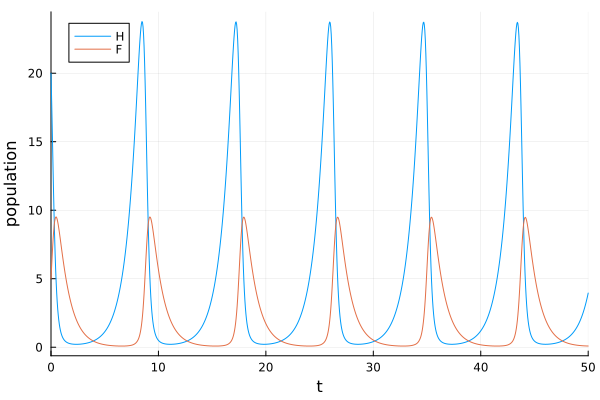

In [6]:
function predator_prey(u, p, t)
    H, F = u
    α, β, γ, δ = p
    return [α * H - β * H * F, δ * H * F - γ * F]
end

u0 = [20.0, 5.0]
tspan = (0.0, 50.0)

α = 1.0
β = 0.5
γ = 1.0
δ = 0.2
p = [α, β, γ, δ]

prob = ODEProblem(predator_prey, u0, tspan, p)
sol = solve(prob)

plot(sol, xlabel = "t", ylabel = "population", label = ["H" "F"])

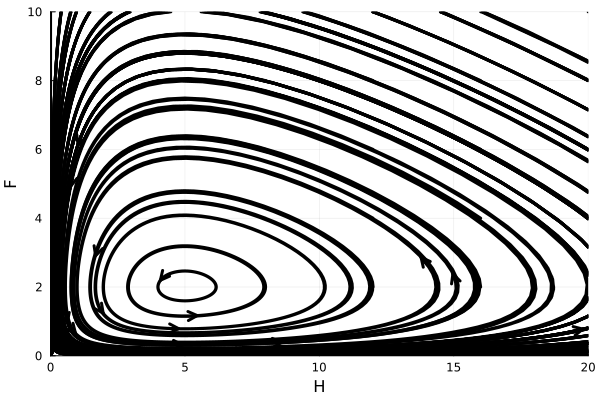

In [7]:
H_grid = 0:4:20
F_grid = 0:2:10

phase_plot = PhasePlot(prob)
plot(
    phase_plot,
    H_grid,
    F_grid;
    legend = nothing, 
    linewidth = 3, 
    xlabel = "H", 
    ylabel = "F",
)

- The fixed points of the LV predator prey model are at $(0,0)$ and (taken from analytic analysis) at $(\gamma/\delta, \alpha/\beta) = (5,2)$. 
<br><br>
- We can determine their stability with the procedure from the lecture. The Jacobian of the system is 

$$J = \begin{pmatrix}\alpha - \beta F & -\beta H\\ \delta F & \delta H - \gamma\end{pmatrix}.$$

- At the origin, this yields

$$J(0,0) = \begin{pmatrix}\alpha & 0\\ 0 & - \gamma\end{pmatrix},$$

with the eigenvalues following directly as $\lambda_1=\alpha$ and $\lambda_2=-\gamma$, so here: $\lambda_1 = 1.$ and $\lambda_2=-1$. Since $\det{J}=-\alpha\gamma < 0$, then we can classify $(0,0)$ as a saddle point.

- The other, oscillatory  point yields
$$J(\gamma/\delta, \alpha/\beta) = \begin{pmatrix}0 & -\frac{\beta\gamma}{\delta}\\ \frac{\alpha\delta}{\beta} & 0\end{pmatrix}.$$
<br>
- This matrix has a zero trace and therefore purely imaginary eigenvalues. This is an example of a *marginal* or *borderline* case, where we can no longer neglect the quadratic terms and the linearization may not hold (see, e.g., Strogatz). We will not go into the details of a further analytical analysis of these oscillations here, but the visual analysis of the phase portrait shows that we have elliptic, closed orbits around the fixed point $(5,2)$.